In [2]:
%load_ext autoreload
%autoreload 2
import copy
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt

import abstract_gradient_training as agt
from abstract_gradient_training.bounds import interval_bound_propagation as ibp
from abstract_gradient_training import AGTConfig
from models.fully_connected import FullyConnected
from datasets.blobs import get_dataloaders

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preliminaries

Set the plotting style, abstract gradient training configuration, prepare the blobs dataset and initialise the model.

In [3]:
# Set plotting and functional parameters
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"

CM_BRIGHT = mpl.colors.ListedColormap(["#F45B69", "#3ABEFF"])
CM_NOMINAL = mpl.colors.ListedColormap(["#FF0000"])
CM_PRIVACY = mpl.colors.ListedColormap(["#f3f7f2", "#B5FFE1", "#93E5AB", "#65B891", "#4E878C", "#00241B"])
CM_UNLEARNING = mpl.colors.ListedColormap(["#f7f5f7", "#DDC4DD", "#DCCFEC", "#A997DF", "#4F517D", "#1A3A3A"])
MARKERSIZE = 7
GRIDSIZE = 1000
GRIDLIM = 3.8
FIGSIZE = (6, 6)
SEED = 1234
HIDDEN_DIM = 128
HIDDEN_LAY = 1
BATCHSIZE = 2000
KS_PRIVACY = [5, 10, 15, 20]
KS_UNLEARNING = [10, 50, 100, 150]
torch.manual_seed(SEED)

# Set the nominal configuration for the certified training
NOMINAL_CONFIG = AGTConfig(
    learning_rate=2.0,
    l2_reg=0.02,
    n_epochs=3,
    device="cuda:0",
    forward_bound="interval+crown",
    backward_bound="interval",
    loss="cross_entropy",
    lr_decay=0.6,
    lr_min=1e-3,
    early_stopping=False,
    log_level="WARNING",
)

[AGT] [WARNING ] [20:04:14] k=0 suffers from numerical instability, consider using dtype double or setting k > 0.


In [4]:
DL_TRAIN_CLOSE, DL_TEST_CLOSE = get_dataloaders(BATCHSIZE, 1, 0.75, SEED)
DL_TRAIN_FAR, DL_TEST_FAR = get_dataloaders(BATCHSIZE, 1.25, 0.35, SEED)

# Initialise the neural network model
MODEL = FullyConnected(in_dim=6, out_dim=2, hidden_dim=HIDDEN_DIM, hidden_lay=HIDDEN_LAY)

# Sweep and plotting functions

Define functions for sweeping over a specific AGT config parameter and plotting the results as a contour plot.

In [5]:
def run_sweep(sweep_variable, sweep_values, config, dl, dl_test, type):
    """
    For the config parameter with name sweep_variable, run certified training for sweep_variable set to each value
    in sweep_values.
    """
    config = copy.deepcopy(config)
    results = []
    for v in sweep_values:
        config.__setattr__(sweep_variable, v)
        torch.manual_seed(SEED)
        if type == "unlearning":
            param_l, param_n, param_u = agt.unlearning_certified_training(MODEL, config, dl, dl_test)
        elif type == "privacy":
            param_l, param_n, param_u = agt.privacy_certified_training(MODEL, config, dl, dl_test)
        results.append((v, param_l, param_n, param_u))

    for _, _, p_n, _ in results:
        assert all([torch.allclose(p_n[i], param_n[i]) for i in range(len(param_n))])
    return results


def plot_sweep(results, dl_test, ax, cm, plot_cbar=False):
    """
    Given the parameter bounds in the results list returned from run_sweep, compute the worst-case predictions for a
    grid of points covering the half-moon dataset and plot the results as a contour plot.
    """

    # get the whole test dataset
    x_test, y_test = dl_test.dataset.tensors

    # define a grid of points to evaluate the model at
    x = torch.linspace(-GRIDLIM, GRIDLIM, GRIDSIZE)
    y = torch.linspace(-GRIDLIM, GRIDLIM, GRIDSIZE)
    X, Y = torch.meshgrid(x, y)

    # add polynomial features
    in_data = torch.stack(
        (
            X.flatten(),
            Y.flatten(),
            X.flatten() ** 2,
            Y.flatten() ** 2,
            X.flatten() ** 3,
            Y.flatten() ** 3,
        ),
        dim=1,
    )

    in_data = in_data.unsqueeze(-1).to(NOMINAL_CONFIG.device).float()

    # compute the nominal model predictions
    param_n = results[0][2]
    *_, logits = agt.nominal_pass.nominal_forward_pass(in_data, param_n)
    logits = logits.argmax(dim=1).reshape(GRIDSIZE, GRIDSIZE)
    worst_case_0 = torch.zeros_like(logits)
    worst_case_1 = torch.zeros_like(logits)
    logits = logits.detach().cpu().numpy()
    ax.contour(X, Y, logits, cmap=CM_NOMINAL, alpha=1.0, levels=[0.5])

    # for each result in the sweep, compute the worst-case predictions for the entire grid
    for _, param_l, param_n, param_u in results:
        (*_, logits_l), (*_, logits_u) = ibp.bound_forward_pass(param_l, param_u, in_data, in_data)
        worst_case_0 += torch.hstack([logits_l[:, 0], logits_u[:, 1]]).argmax(dim=1).reshape(GRIDSIZE, GRIDSIZE)
        worst_case_1 += 1 - torch.hstack([logits_u[:, 0], logits_l[:, 1]]).argmax(dim=1).reshape(GRIDSIZE, GRIDSIZE)

    # plot the worst-case predictions
    worst_case = torch.min(worst_case_0, worst_case_1).detach().cpu().numpy()
    boundaries = list(range(-1, len(results) + 1, 1))
    # norm = mpl.colors.Normalize(vmin=worst_case.min(), vmax=worst_case.max())
    cont = ax.contourf(X, Y, worst_case, cmap=cm, alpha=0.8, levels=boundaries)
    tick_positions = [(boundaries[i] + boundaries[i + 1]) / 2 for i in range(len(boundaries) - 1)]

    # define custom colorbar
    if plot_cbar:
        cbar = plt.colorbar(cont, ticks=tick_positions[1:], boundaries=boundaries[1:], ax=ax, shrink=0.8)
        cbar.ax.set_ylim(0, len(results))
        cbar.set_ticklabels([f"$k={r[0]}$" for r in reversed(results)])  # Set custom tick labels

    # plot the test dataset
    ax.scatter(x_test[:, 0], x_test[:, 1], s=MARKERSIZE, c=y_test, edgecolors="#c0d1c9", linewidths=0.4, cmap=CM_BRIGHT)

# Run all sweeps

Define the sweep configurations and run all sweeps to get parameter bounds.

In [6]:
low_privacy_config = copy.deepcopy(NOMINAL_CONFIG)
low_privacy_config.dp_sgd_sigma = 0.001
low_privacy_config.clip_gamma = 1.0

high_privacy_config = copy.deepcopy(NOMINAL_CONFIG)
high_privacy_config.dp_sgd_sigma = 0.01
high_privacy_config.clip_gamma = 0.1

# Run sweeps for close and far blobs datasets, for privacy and unlearning
results_low_close_privacy = run_sweep(
    "k_private", KS_PRIVACY, low_privacy_config, DL_TRAIN_CLOSE, DL_TEST_CLOSE, "privacy"
)
results_low_close_unlearning = run_sweep(
    "k_unlearn", KS_UNLEARNING, low_privacy_config, DL_TRAIN_CLOSE, DL_TEST_CLOSE, "unlearning"
)
results_high_close_privacy = run_sweep(
    "k_private", KS_PRIVACY, high_privacy_config, DL_TRAIN_CLOSE, DL_TEST_CLOSE, "privacy"
)
results_high_close_unlearning = run_sweep(
    "k_unlearn", KS_UNLEARNING, high_privacy_config, DL_TRAIN_CLOSE, DL_TEST_CLOSE, "unlearning"
)
results_low_far_privacy = run_sweep("k_private", KS_PRIVACY, low_privacy_config, DL_TRAIN_FAR, DL_TEST_FAR, "privacy")
results_low_far_unlearning = run_sweep(
    "k_unlearn", KS_UNLEARNING, low_privacy_config, DL_TRAIN_FAR, DL_TEST_FAR, "unlearning"
)
results_high_far_privacy = run_sweep("k_private", KS_PRIVACY, high_privacy_config, DL_TRAIN_FAR, DL_TEST_FAR, "privacy")
results_high_far_unlearning = run_sweep(
    "k_unlearn", KS_UNLEARNING, high_privacy_config, DL_TRAIN_FAR, DL_TEST_FAR, "unlearning"
)

# Plot all results

Plot the results of all sweeps, showing the "certified" region for each setting of k.

/vol/bitbucket/ps1623/venv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Text(0.23, 1.01, 'DP-SGD Params: $\\gamma=1.0, \\sigma = 0.001$')

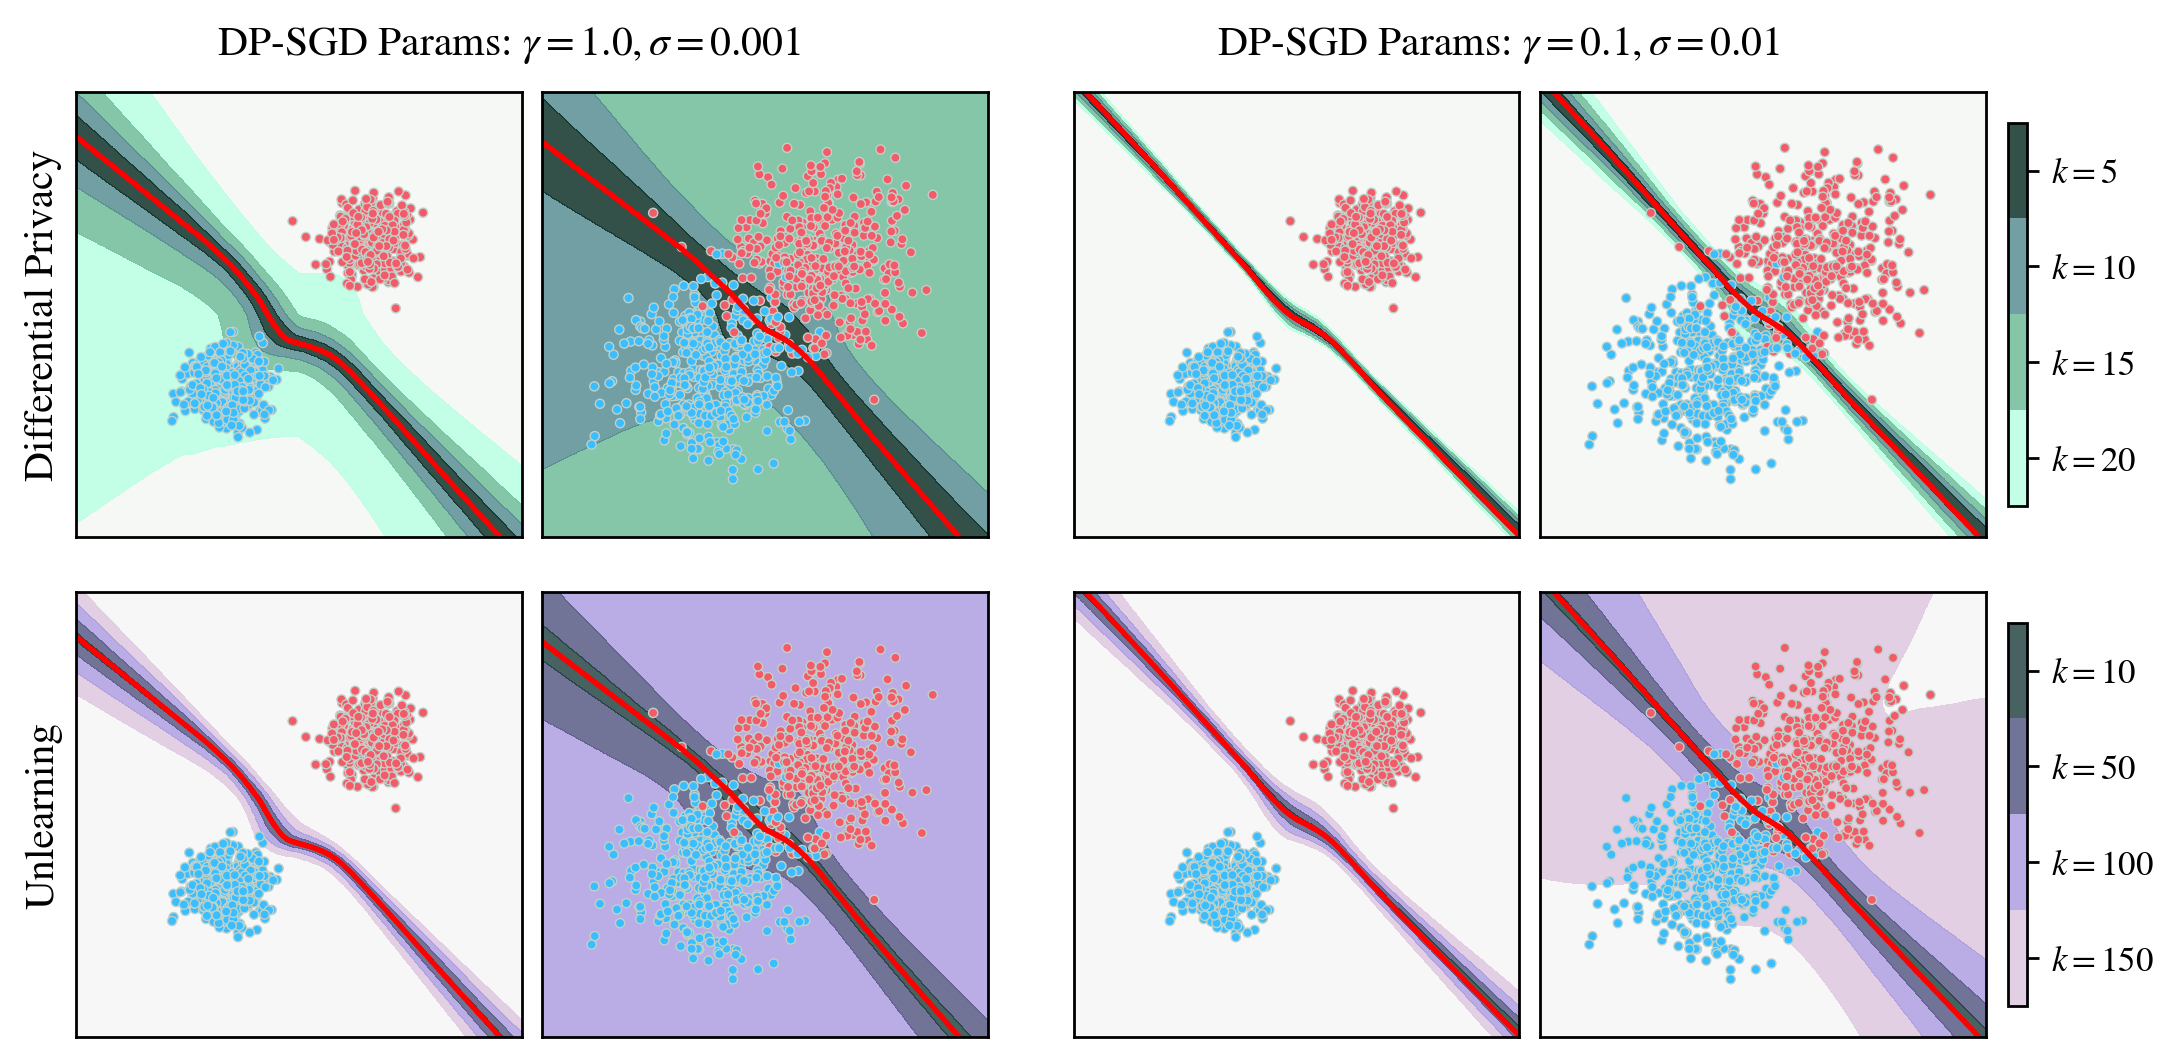

In [7]:
fig, axs = plt.subplots(
    2, 5, figsize=(8.6, 4), dpi=250, sharex=True, sharey=True, layout="constrained", width_ratios=[1, 1, 0.1, 1, 1]
)
axs[0][2].set_visible(False)
axs[1][2].set_visible(False)
for j in range(5):
    for i in range(2):
        if j == 2:
            continue
        axs[i][j].set_aspect("equal")
        axs[i][j].set_yticks([])
        axs[i][j].set_xticks([])
        axs[i][j].set_xlim(-GRIDLIM, GRIDLIM)
        axs[i][j].set_ylim(-GRIDLIM, GRIDLIM)

plot_sweep(results_low_far_privacy, DL_TEST_FAR, axs[0][0], CM_PRIVACY, False)
plot_sweep(results_low_close_privacy, DL_TEST_CLOSE, axs[0][1], CM_PRIVACY, False)
plot_sweep(results_high_far_privacy, DL_TEST_FAR, axs[0][3], CM_PRIVACY, False)
plot_sweep(results_high_close_privacy, DL_TEST_CLOSE, axs[0][4], CM_PRIVACY, True)

plot_sweep(results_low_far_unlearning, DL_TEST_FAR, axs[1][0], CM_UNLEARNING, False)
plot_sweep(results_low_close_unlearning, DL_TEST_CLOSE, axs[1][1], CM_UNLEARNING, False)
plot_sweep(results_high_far_unlearning, DL_TEST_FAR, axs[1][3], CM_UNLEARNING, False)
plot_sweep(results_high_close_unlearning, DL_TEST_CLOSE, axs[1][4], CM_UNLEARNING, True)

axs[0][0].set_ylabel("Differential Privacy", fontsize="large")
axs[1][0].set_ylabel("Unlearning", fontsize="large")
fig.text(0.69, 1.01, "DP-SGD Params: $\gamma=0.1, \sigma = 0.01$", ha="center", fontsize="large")
fig.text(0.23, 1.01, "DP-SGD Params: $\gamma=1.0, \sigma = 0.001$", ha="center", fontsize="large")